In [4]:
pip install geopandas rasterio -i https://mirrors.aliyun.com/pypi/simple/


Note: you may need to restart the kernel to use updated packages.Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
      --------------------------------------- 0.0/1.1 MB 320.0 kB/s eta 0:00:04
     - -------------------------------------- 0.0/1.1 MB 393.8 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/1.1 MB 465.5 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/1.1 MB 456.6 kB/s eta 0:00:03
     --- ------------------------------------ 0.1/1.1 MB 420.8 kB/s eta 0:00:03
     ---- ----------------------------------- 0.1/1.1 MB 423.5 kB/s eta 0:00:03
     ----- ---------------------------------- 0.1/1.1 MB 425.3 kB/s eta 0:00:03
     ----- ---------------------------------- 0.2/1.1 MB 437.1 kB/s eta 0:00:03
     ----- ---------------------------------- 0.2/1.1 MB 377.4 kB/s eta 0:00:03
     ------ --------------------------------- 0.2/1.1 MB 384.3 kB/s eta 0:00:03
    

## shapfile像素(pixel)的mean

In [36]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.mask import mask
import os
shapefile_path = r"C:\Users\Administrator\Downloads\sho\Cut\Soybean_1.shp"
gdf = gpd.read_file(shapefile_path)

print(gdf.info())
print(gdf.head())
tif_folder = r"C:\Users\Administrator\Downloads\Phase_Coherence"
tif_files = [os.path.join(tif_folder, f) for f in os.listdir(tif_folder) if f.endswith('.tif')]
def reproject_shapefile(gdf, tif_file):
    with rasterio.open(tif_file) as src:
        raster_crs = src.crs
    return gdf.to_crs(raster_crs)

#计算shapefile图形下的像素均值
def calculate_mean_value(shapefile, tif_file):
    shapefile = reproject_shapefile(shapefile, tif_file)
    with rasterio.open(tif_file) as src:
        for geom in shapefile.geometry:
            try:
                out_image, out_transform = mask(src, [geom], crop=True)
                out_image = out_image[0] 
                # 排除无效值
                valid_data = out_image[(out_image != src.nodata) & (~np.isnan(out_image))]
                mean_value = valid_data.mean() if valid_data.size > 0 else None

                print(f"Mean value for geometry {geom}: {mean_value}")
            except ValueError as e:
                print(f"Skipping geometry {geom} due to error: {e}")

# 遍历所有tif文件并计算均值
for tif_file in tif_files:
    calculate_mean_value(gdf, tif_file)


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CLASS_ID    1 non-null      object  
 1   CLASS_NAME  1 non-null      object  
 2   AREA        1 non-null      float64 
 3   geometry    3 non-null      geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 228.0+ bytes
None
  CLASS_ID CLASS_NAME     AREA  \
0        1  Soybean_1  14162.0   
1     None       None      NaN   
2     None       None      NaN   

                                            geometry  
0  POLYGON ((547338.000 4725234.000, 547335.000 4...  
1  POLYGON ((546976.499 4725703.461, 547228.210 4...  
2  POLYGON ((546980.230 4725701.242, 547224.781 4...  
Mean value for geometry POLYGON ((-80.42223263907515 42.67812562798365, -80.4222692527096 42.67812581265323, -80.42226900243718 42.67815282807336, -80.42230561608783 42.678153012731414, -80.4223053658309 42.6

## 计算两个tif文件的像素差值和mean

In [50]:
# 计算shapefile图形下的像素差异均值
def calculate_mean_difference(shapefile, tif_file1, tif_file2):
    shapefile = reproject_shapefile(shapefile, tif_file1)
    
    with rasterio.open(tif_file1) as src1, rasterio.open(tif_file2) as src2:
        nodata1 = src1.nodata
        nodata2 = src2.nodata

        if nodata1 is None:
            print(f"No nodata value found for {tif_file1}")
        if nodata2 is None:
            print(f"No nodata value found for {tif_file2}")

        for geom in shapefile.geometry:
            try:
                out_image1, out_transform1 = mask(src1, [geom], crop=True)
                out_image2, out_transform2 = mask(src2, [geom], crop=True)            
                out_image1 = out_image1[0]  
                out_image2 = out_image2[0]  
                print(f"Out image 1 unique values: {np.unique(out_image1)}")
                print(f"Out image 2 unique values: {np.unique(out_image2)}")
                # 计算两个图像的差异
                difference = out_image1 - out_image2
                print(f"Difference unique values: {np.unique(difference)}")
                valid_data = difference[(difference != nodata1) & (~np.isnan(difference))]
                mean_difference = valid_data.mean() if valid_data.size > 0 else None
                print(f"Mean difference value for geometry {geom}: {mean_difference}")
            except ValueError as e:
                print(f"Skipping geometry {geom} due to error: {e}")

if len(tif_files) >= 2:
    calculate_mean_difference(gdf, tif_files[0], tif_files[1])
else:
    print("Not enough tif files to perform comparison.")

Out image 1 unique values: [0.01180567 0.02880778 0.03082181 0.03348415 0.04180593 0.04360596
 0.05087087 0.05217712 0.053063   0.05556878 0.05611527 0.05859433
 0.06370168 0.0639736  0.06494614 0.0663674  0.0689028  0.07085637
 0.07189044 0.07601643 0.07844517 0.08233757 0.08252805 0.08347876
 0.08414758 0.08468023 0.08645748 0.08765705 0.0881843  0.09071862
 0.0907853  0.09272998 0.09463261 0.09648069 0.09717369 0.09820045
 0.09915303 0.10062333 0.1009043  0.10136383 0.10139895 0.10273322
 0.10344046 0.10431872 0.10850979 0.10969902 0.11112336 0.11136079
 0.11339572 0.1141405  0.11556892 0.11707195 0.12157255 0.12179869
 0.1228703  0.12433616 0.12554051 0.12565584 0.12655513 0.12681626
 0.12741327 0.1276092  0.128398   0.13059269 0.13139394 0.13178192
 0.13205    0.13342914 0.13480887 0.1349565  0.13552894 0.13577852
 0.13643223 0.13724574 0.13896157 0.14019398 0.14103766 0.14119007
 0.1425477  0.14397685 0.14406341 0.14551494 0.1463676  0.14767472
 0.1477534  0.14911485 0.14927417 0

## 保存成excel

In [43]:
results = pd.DataFrame(columns=['Date', 'Type', 'Mean Value'])
for tif_file in tif_files:
    file_name = os.path.basename(tif_file)
    file_parts = file_name.split('_')
    file_type = file_parts[0]
    file_date = file_parts[1].split('.')[0]

    mean_values = calculate_mean_value(gdf, tif_file)
    for mean_value in mean_values:
        new_row = pd.DataFrame({'Date': [file_type], 'Type': [file_date], 'Mean Value': [mean_value]})
        results = pd.concat([results, new_row], ignore_index=True)

# 将结果写入Excel文件
output_excel_path = r"C:\Users\Administrator\Downloads\mean_values.xlsx"
results.to_excel(output_excel_path, index=False)

print("已保存")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15304\2834064636.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


已保存


## 画出关于type的折线图

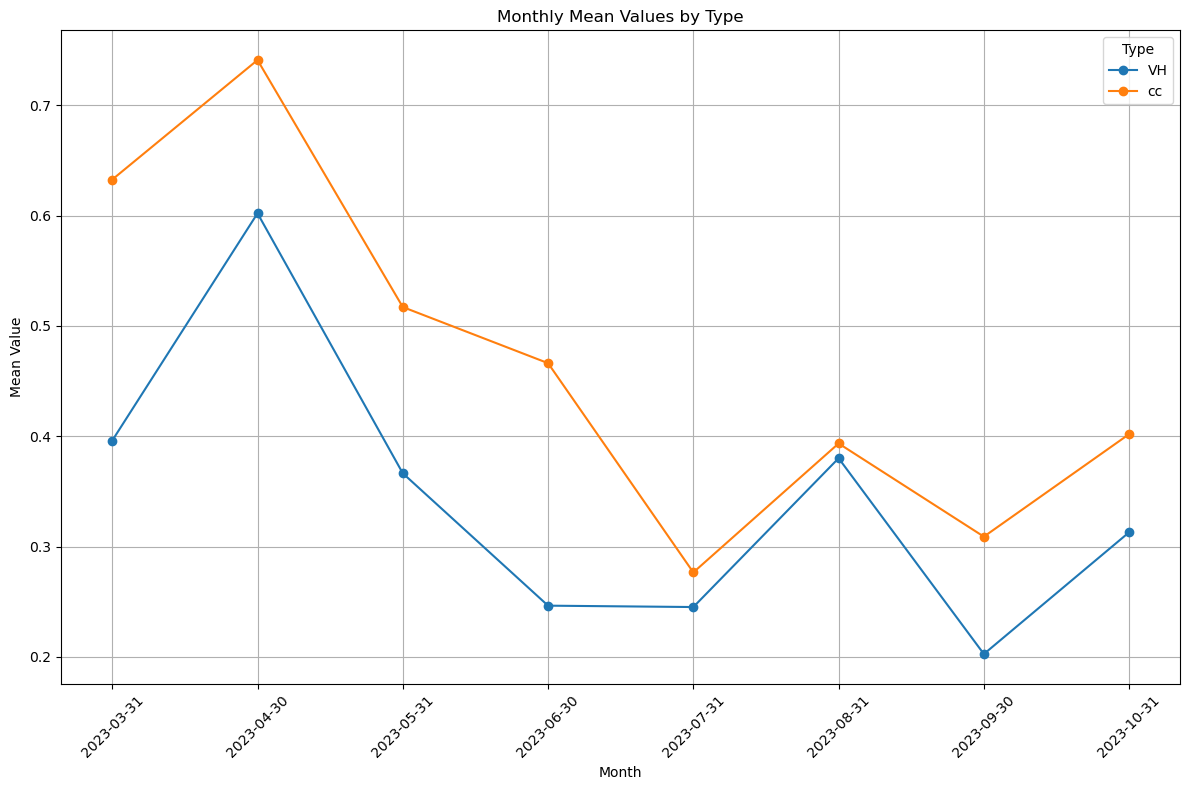

In [72]:
import pandas as pd
import re
import matplotlib.pyplot as plt

file_path = r'C:\Users\Administrator\Downloads\mean_values.xlsx'
df = pd.read_excel(file_path)

df['Month'] = df['Date'].apply(lambda x: re.search(r'\d+\.\d+', x).group(0) if re.search(r'\d+\.\d+', x) else None)
df['Month'] = pd.to_datetime('2023.' + df['Month'], format='%Y.%m.%d')
monthly_mean_by_type = df.groupby(['Type', df['Month'].dt.to_period('M')])['Mean Value'].mean().reset_index()

plt.figure(figsize=(12, 8))
for type_label in monthly_mean_by_type['Type'].unique():
    type_data = monthly_mean_by_type[monthly_mean_by_type['Type'] == type_label]
    plt.plot(type_data['Month'].dt.strftime('%Y-%m-%d'), type_data['Mean Value'], marker='o', label=type_label)

plt.title('Monthly Mean Values by Type')
plt.xlabel('Month')
plt.ylabel('Mean Value')
plt.legend(title='Type')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


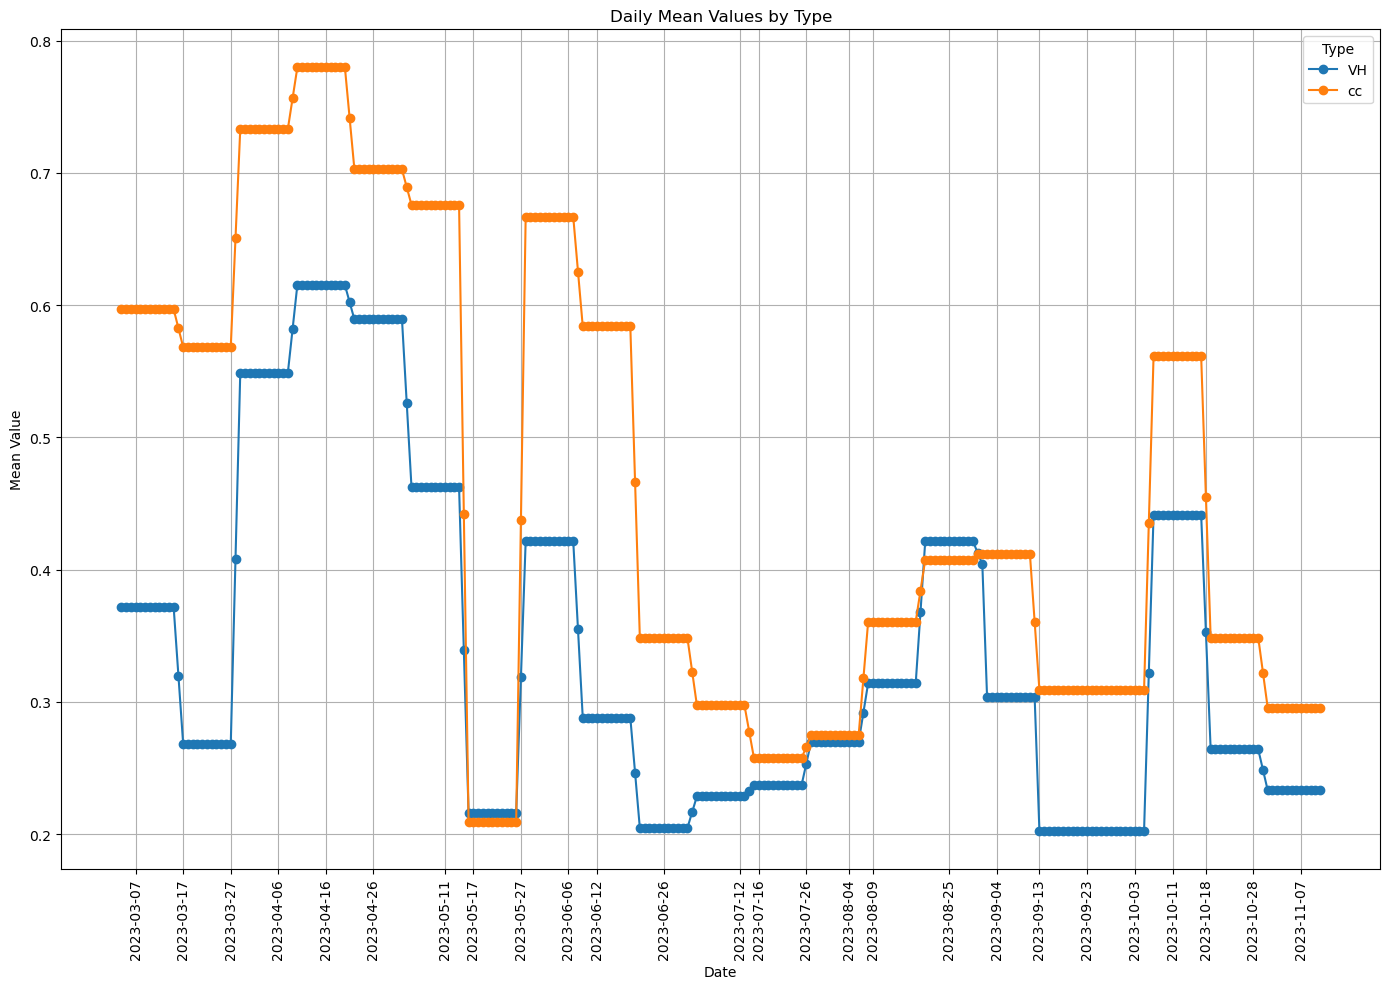

In [75]:
def extract_dates(date_range):
    try:
        if '-' in date_range:
            start_date, end_date = date_range.split('-')
            start_date = pd.to_datetime('2023.' + start_date, format='%Y.%m.%d')
            end_date = pd.to_datetime('2023.' + end_date, format='%Y.%m.%d')
            return pd.date_range(start=start_date, end=end_date).strftime('%Y-%m-%d')
        else:
            single_date = pd.to_datetime('2023.' + date_range, format='%Y.%m.%d')
            return [single_date.strftime('%Y-%m-%d')]
    except Exception as e:
        return []

df['Dates'] = df['Date'].apply(lambda x: extract_dates(x))
df = df[df['Dates'].apply(lambda x: len(x) > 0)]
df_exploded = df.explode('Dates').reset_index(drop=True)
df_exploded['Dates'] = pd.to_datetime(df_exploded['Dates'], format='%Y-%m-%d')

daily_mean_by_type = df_exploded.groupby(['Type', df_exploded['Dates']])['Mean Value'].mean().reset_index()

plt.figure(figsize=(14, 10))
for type_label in daily_mean_by_type['Type'].unique():
    type_data = daily_mean_by_type[daily_mean_by_type['Type'] == type_label]
    plt.plot(type_data['Dates'].dt.strftime('%Y-%m-%d'), type_data['Mean Value'], marker='o', label=type_label)

plt.title('Daily Mean Values by Type')
plt.xlabel('Date')
plt.ylabel('Mean Value')
plt.legend(title='Type')
plt.grid(True)

# 设置x轴标签每隔10天显示一次
xticks = df_exploded['Dates'].dt.strftime('%Y-%m-%d').unique()
plt.xticks(ticks=xticks[::10], rotation=90)

plt.tight_layout()

# Show the plot
plt.show()

In [79]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 读取图像
image_path = r'C:\Users\Administrator\Downloads\0000.png'
image = cv2.imread(image_path)

# 转换为灰度图像
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 应用高斯模糊来减少噪声
blurred_image = cv2.GaussianBlur(gray_image, (11, 11), 0)

# 使用自适应阈值处理，更适合光照不均匀的情况
threshold_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# 寻找轮廓
contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 在原始图像上标注污渍
for contour in contours:
    if cv2.contourArea(contour) > 50:  # 过滤掉较小的污渍
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# 保存结果图像
output_path =r'C:\Users\Administrator\Downloads\0000_detected.png'
cv2.imwrite(output_path, image)

output_path


'C:\\Users\\Administrator\\Downloads\\0000_detected.png'